# train.ipynb: 用所有的训练集训练决策树
这里需要用到预处理过的数据，以减少代码运算时间。请先跑`waveform.py`。

In [1]:
import os
import multiprocessing
import numpy as np
import h5py
from utils import loadData, getNum, getPePerWF, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

`waveform.py`预处理后的数据在./train中，文件名格式为`f"final_{i}_wf.h5"`

In [2]:
trainPathRoot = './data/final-'
processedPathRoot = './train/final_'

从预处理的数据中，读取训练两个训练集需要的原始数据，并将18个训练集的数据拼接起来。
1. `intTrainWF`: 波形积分
2. `pointsPerTrainWF`: 超过阈值的点数
3. `pePerTrainWFCalc`: 每个波形对应的PE数计算值
4. `meanPeTimePerTrainWF`: 每个波形对应的PETime的手算平均值
5. `pePerTrainWF`: 每个波形对应的PE数真值
6. `wfIndices`: (n+1,)的ndarray，下标为i表示EventID=i的第一次出现在Waveform表中的下标，下标为n表示Waveform表长度

In [3]:
intTrainWF = np.array([], dtype='<i4') # 读取波形积分
pointsPerTrainWF = np.array([], dtype='<i2') # 读取超过阈值的点数
pePerTrainWFCalc = np.array([], dtype='<i2') # 读取每个波形对应的PE数计算值
meanPeTimePerTrainWF = np.array([], dtype='<f8') # 读取每个波形对应的PETime的手算平均值
pePerTrainWF = np.array([], dtype='<i2') # 读取每个波形对应的PE数真值

wfIndices = np.array([0], dtype=int)
p = np.array([], dtype='<f8')

previousIndex = 0
print("正在读取预处理后的数据集...")
for i in tqdm(range(2, 20)):
    with h5py.File(f"{processedPathRoot}{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])
        pePerTrainWF = np.append(pePerTrainWF, ipt['Waveform']['pePerWF'][...])
        
        wfIndicesChunk = ipt['WfIndices'][...]
        trainPT = loadData(f"./data/final-{i}.h5", 'p')
        
        wfIndices = np.append(wfIndices, np.zeros(trainPT.shape[0]))
        p = np.append(p, np.zeros(trainPT.shape[0]))
        finalIndex = previousIndex + trainPT.shape[0] + 1
        wfIndices[previousIndex:finalIndex] = wfIndicesChunk + wfIndices[previousIndex]
        p[previousIndex:(finalIndex-1)] = trainPT['p']
        previousIndex = finalIndex-1

  0%|          | 0/18 [00:00<?, ?it/s]

正在读取预处理后的数据集...


100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


下面的代码和`model.ipynb`是完全一样的，除了训练集、验证集大小不一样。

In [4]:
print("正在计算PE总数，平均值和标准差...")
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])

for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

print("正在计算PETime平均值和标准差...")
splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)

  3%|▎         | 1186/35996 [00:00<00:02, 11856.56it/s]

正在计算计算PE总数，平均值和标准差...


  1%|▏         | 536/35996 [00:00<00:06, 5359.33it/s]

正在计算PETime平均值和标准差...


100%|██████████| 35996/35996 [00:06<00:00, 5386.28it/s]


In [5]:
trainDataForP = lgb.Dataset(
    np.stack(
        (
            peTotal[:-3600],
            peMean[:-3600],
            peStd[:-3600],
            peTimeMean[:-3600],
            peTimeStd[:-3600],
        ),
        axis=1
    ),
    label=p[:-3600]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (
            peTotal[-3600:],
            peMean[-3600:],
            peStd[-3600:],
            peTimeMean[-3600:],
            peTimeStd[-3600:],
        ),
        axis=1
    ),
    label=p[-3600:],
    reference=trainDataForP
)
trainDataPath = './train/trainDataForP.bin'
validDataPath = './train/validDataForP.bin'
if os.path.exists(trainDataPath):
    os.remove(trainDataPath)
if os.path.exists(validDataPath):
    os.remove(validDataPath)
trainDataForP.save_binary('./train/trainDataForP.bin')
validationDataForP.save_binary('./train/validDataForP.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainDataForP.bin
[LightGBM] [Info] Saving data to binary file ./train/validDataForP.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


In [6]:
trainDataForP = lgb.Dataset('./train/trainDataForP.bin')
validationDataForP = lgb.Dataset('./train/validDataForP.bin')

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'custom'},
    'num_leaves': 2**10,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 0.1,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=1000,
    fobj=lossfunc_train,
    feval=lossfunc_eval,
)
gbmForP.save_model('model/modelPCalc.txt')

[1]	valid_0's custom: 5.4757
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's custom: 5.46476
[3]	valid_0's custom: 5.45384
[4]	valid_0's custom: 5.44293
[5]	valid_0's custom: 5.43205
[6]	valid_0's custom: 5.42122
[7]	valid_0's custom: 5.4104
[8]	valid_0's custom: 5.3996
[9]	valid_0's custom: 5.38883
[10]	valid_0's custom: 5.37808
[11]	valid_0's custom: 5.36735
[12]	valid_0's custom: 5.35664
[13]	valid_0's custom: 5.34596
[14]	valid_0's custom: 5.3353
[15]	valid_0's custom: 5.32466
[16]	valid_0's custom: 5.31403
[17]	valid_0's custom: 5.30343
[18]	valid_0's custom: 5.29284
[19]	valid_0's custom: 5.28228
[20]	valid_0's custom: 5.27174
[21]	valid_0's custom: 5.26125
[22]	valid_0's custom: 5.25078
[23]	valid_0's custom: 5.24033
[24]	valid_0's custom: 5.2299
[25]	valid_0's custom: 5.21949
[26]	valid_0's custom: 5.2091
[27]	valid_0's custom: 5.19872
[28]	valid_0's custom: 5.18837
[29]	valid_0's custom: 5.17804
[30]	valid_0's custom: 5.16773
[31]	valid_0's custom:

[277]	valid_0's custom: 3.15761
[278]	valid_0's custom: 3.15133
[279]	valid_0's custom: 3.14506
[280]	valid_0's custom: 3.13881
[281]	valid_0's custom: 3.13255
[282]	valid_0's custom: 3.12631
[283]	valid_0's custom: 3.12009
[284]	valid_0's custom: 3.11388
[285]	valid_0's custom: 3.10767
[286]	valid_0's custom: 3.10148
[287]	valid_0's custom: 3.09531
[288]	valid_0's custom: 3.08914
[289]	valid_0's custom: 3.08299
[290]	valid_0's custom: 3.07685
[291]	valid_0's custom: 3.07072
[292]	valid_0's custom: 3.06461
[293]	valid_0's custom: 3.05851
[294]	valid_0's custom: 3.05242
[295]	valid_0's custom: 3.04635
[296]	valid_0's custom: 3.04027
[297]	valid_0's custom: 3.03421
[298]	valid_0's custom: 3.02816
[299]	valid_0's custom: 3.02212
[300]	valid_0's custom: 3.01609
[301]	valid_0's custom: 3.01009
[302]	valid_0's custom: 3.00409
[303]	valid_0's custom: 2.99811
[304]	valid_0's custom: 2.99214
[305]	valid_0's custom: 2.98619
[306]	valid_0's custom: 2.98024
[307]	valid_0's custom: 2.9743
[308]	val

[544]	valid_0's custom: 1.85513
[545]	valid_0's custom: 1.85144
[546]	valid_0's custom: 1.84776
[547]	valid_0's custom: 1.84409
[548]	valid_0's custom: 1.84043
[549]	valid_0's custom: 1.83678
[550]	valid_0's custom: 1.83313
[551]	valid_0's custom: 1.82948
[552]	valid_0's custom: 1.82585
[553]	valid_0's custom: 1.82222
[554]	valid_0's custom: 1.8186
[555]	valid_0's custom: 1.81499
[556]	valid_0's custom: 1.81139
[557]	valid_0's custom: 1.80779
[558]	valid_0's custom: 1.8042
[559]	valid_0's custom: 1.80062
[560]	valid_0's custom: 1.79704
[561]	valid_0's custom: 1.79347
[562]	valid_0's custom: 1.7899
[563]	valid_0's custom: 1.78634
[564]	valid_0's custom: 1.78279
[565]	valid_0's custom: 1.77925
[566]	valid_0's custom: 1.77571
[567]	valid_0's custom: 1.77218
[568]	valid_0's custom: 1.76866
[569]	valid_0's custom: 1.76514
[570]	valid_0's custom: 1.76163
[571]	valid_0's custom: 1.75813
[572]	valid_0's custom: 1.75464
[573]	valid_0's custom: 1.75116
[574]	valid_0's custom: 1.74768
[575]	valid

[806]	valid_0's custom: 1.1024
[807]	valid_0's custom: 1.10022
[808]	valid_0's custom: 1.09805
[809]	valid_0's custom: 1.09588
[810]	valid_0's custom: 1.09372
[811]	valid_0's custom: 1.09155
[812]	valid_0's custom: 1.08939
[813]	valid_0's custom: 1.08722
[814]	valid_0's custom: 1.08507
[815]	valid_0's custom: 1.08291
[816]	valid_0's custom: 1.08077
[817]	valid_0's custom: 1.07863
[818]	valid_0's custom: 1.0765
[819]	valid_0's custom: 1.07437
[820]	valid_0's custom: 1.07224
[821]	valid_0's custom: 1.07012
[822]	valid_0's custom: 1.068
[823]	valid_0's custom: 1.06588
[824]	valid_0's custom: 1.06377
[825]	valid_0's custom: 1.06166
[826]	valid_0's custom: 1.05956
[827]	valid_0's custom: 1.05746
[828]	valid_0's custom: 1.05536
[829]	valid_0's custom: 1.05327
[830]	valid_0's custom: 1.05119
[831]	valid_0's custom: 1.0491
[832]	valid_0's custom: 1.04703
[833]	valid_0's custom: 1.04495
[834]	valid_0's custom: 1.04288
[835]	valid_0's custom: 1.04082
[836]	valid_0's custom: 1.03876
[837]	valid_0

[1078]	valid_0's custom: 0.643506
[1079]	valid_0's custom: 0.642239
[1080]	valid_0's custom: 0.640974
[1081]	valid_0's custom: 0.63971
[1082]	valid_0's custom: 0.638448
[1083]	valid_0's custom: 0.637189
[1084]	valid_0's custom: 0.635932
[1085]	valid_0's custom: 0.634677
[1086]	valid_0's custom: 0.633429
[1087]	valid_0's custom: 0.632184
[1088]	valid_0's custom: 0.630941
[1089]	valid_0's custom: 0.629701
[1090]	valid_0's custom: 0.628462
[1091]	valid_0's custom: 0.627224
[1092]	valid_0's custom: 0.625988
[1093]	valid_0's custom: 0.624755
[1094]	valid_0's custom: 0.623524
[1095]	valid_0's custom: 0.622295
[1096]	valid_0's custom: 0.621067
[1097]	valid_0's custom: 0.619841
[1098]	valid_0's custom: 0.618617
[1099]	valid_0's custom: 0.617396
[1100]	valid_0's custom: 0.616178
[1101]	valid_0's custom: 0.614959
[1102]	valid_0's custom: 0.613743
[1103]	valid_0's custom: 0.61253
[1104]	valid_0's custom: 0.611319
[1105]	valid_0's custom: 0.61011
[1106]	valid_0's custom: 0.608909
[1107]	valid_0's 

[1321]	valid_0's custom: 0.399126
[1322]	valid_0's custom: 0.398348
[1323]	valid_0's custom: 0.39757
[1324]	valid_0's custom: 0.396794
[1325]	valid_0's custom: 0.39602
[1326]	valid_0's custom: 0.395247
[1327]	valid_0's custom: 0.394476
[1328]	valid_0's custom: 0.393707
[1329]	valid_0's custom: 0.392939
[1330]	valid_0's custom: 0.392172
[1331]	valid_0's custom: 0.391406
[1332]	valid_0's custom: 0.39064
[1333]	valid_0's custom: 0.389876
[1334]	valid_0's custom: 0.389114
[1335]	valid_0's custom: 0.388353
[1336]	valid_0's custom: 0.387596
[1337]	valid_0's custom: 0.38684
[1338]	valid_0's custom: 0.386086
[1339]	valid_0's custom: 0.385333
[1340]	valid_0's custom: 0.384581
[1341]	valid_0's custom: 0.383829
[1342]	valid_0's custom: 0.383079
[1343]	valid_0's custom: 0.38233
[1344]	valid_0's custom: 0.381583
[1345]	valid_0's custom: 0.380836
[1346]	valid_0's custom: 0.380094
[1347]	valid_0's custom: 0.379354
[1348]	valid_0's custom: 0.378615
[1349]	valid_0's custom: 0.377877
[1350]	valid_0's cu

[1580]	valid_0's custom: 0.241201
[1581]	valid_0's custom: 0.240735
[1582]	valid_0's custom: 0.24027
[1583]	valid_0's custom: 0.239806
[1584]	valid_0's custom: 0.239343
[1585]	valid_0's custom: 0.238881
[1586]	valid_0's custom: 0.23842
[1587]	valid_0's custom: 0.23796
[1588]	valid_0's custom: 0.2375
[1589]	valid_0's custom: 0.237042
[1590]	valid_0's custom: 0.236585
[1591]	valid_0's custom: 0.23613
[1592]	valid_0's custom: 0.235677
[1593]	valid_0's custom: 0.235224
[1594]	valid_0's custom: 0.234773
[1595]	valid_0's custom: 0.234322
[1596]	valid_0's custom: 0.233872
[1597]	valid_0's custom: 0.233422
[1598]	valid_0's custom: 0.232974
[1599]	valid_0's custom: 0.232526
[1600]	valid_0's custom: 0.23208
[1601]	valid_0's custom: 0.231634
[1602]	valid_0's custom: 0.23119
[1603]	valid_0's custom: 0.230746
[1604]	valid_0's custom: 0.230304
[1605]	valid_0's custom: 0.229862
[1606]	valid_0's custom: 0.229419
[1607]	valid_0's custom: 0.228978
[1608]	valid_0's custom: 0.228537
[1609]	valid_0's custo

[1837]	valid_0's custom: 0.147636
[1838]	valid_0's custom: 0.147357
[1839]	valid_0's custom: 0.147079
[1840]	valid_0's custom: 0.146801
[1841]	valid_0's custom: 0.146526
[1842]	valid_0's custom: 0.146251
[1843]	valid_0's custom: 0.145976
[1844]	valid_0's custom: 0.145703
[1845]	valid_0's custom: 0.145429
[1846]	valid_0's custom: 0.145155
[1847]	valid_0's custom: 0.144881
[1848]	valid_0's custom: 0.144608
[1849]	valid_0's custom: 0.144335
[1850]	valid_0's custom: 0.144063
[1851]	valid_0's custom: 0.14379
[1852]	valid_0's custom: 0.143518
[1853]	valid_0's custom: 0.143247
[1854]	valid_0's custom: 0.142976
[1855]	valid_0's custom: 0.142706
[1856]	valid_0's custom: 0.142438
[1857]	valid_0's custom: 0.142171
[1858]	valid_0's custom: 0.141904
[1859]	valid_0's custom: 0.141639
[1860]	valid_0's custom: 0.141373
[1861]	valid_0's custom: 0.141105
[1862]	valid_0's custom: 0.140838
[1863]	valid_0's custom: 0.140571
[1864]	valid_0's custom: 0.140304
[1865]	valid_0's custom: 0.140038
[1866]	valid_0'

[2104]	valid_0's custom: 0.0899698
[2105]	valid_0's custom: 0.0898054
[2106]	valid_0's custom: 0.0896417
[2107]	valid_0's custom: 0.0894784
[2108]	valid_0's custom: 0.0893153
[2109]	valid_0's custom: 0.0891526
[2110]	valid_0's custom: 0.0889903
[2111]	valid_0's custom: 0.0888286
[2112]	valid_0's custom: 0.0886673
[2113]	valid_0's custom: 0.0885064
[2114]	valid_0's custom: 0.0883457
[2115]	valid_0's custom: 0.0881854
[2116]	valid_0's custom: 0.0880269
[2117]	valid_0's custom: 0.0878687
[2118]	valid_0's custom: 0.0877108
[2119]	valid_0's custom: 0.0875533
[2120]	valid_0's custom: 0.087396
[2121]	valid_0's custom: 0.0872379
[2122]	valid_0's custom: 0.0870801
[2123]	valid_0's custom: 0.0869227
[2124]	valid_0's custom: 0.0867655
[2125]	valid_0's custom: 0.0866087
[2126]	valid_0's custom: 0.0864527
[2127]	valid_0's custom: 0.086297
[2128]	valid_0's custom: 0.0861416
[2129]	valid_0's custom: 0.0859866
[2130]	valid_0's custom: 0.0858318
[2131]	valid_0's custom: 0.0856773
[2132]	valid_0's custo

[2352]	valid_0's custom: 0.0580396
[2353]	valid_0's custom: 0.0579402
[2354]	valid_0's custom: 0.0578409
[2355]	valid_0's custom: 0.0577418
[2356]	valid_0's custom: 0.0576437
[2357]	valid_0's custom: 0.0575458
[2358]	valid_0's custom: 0.057448
[2359]	valid_0's custom: 0.0573505
[2360]	valid_0's custom: 0.0572531
[2361]	valid_0's custom: 0.057155
[2362]	valid_0's custom: 0.057057
[2363]	valid_0's custom: 0.0569593
[2364]	valid_0's custom: 0.0568617
[2365]	valid_0's custom: 0.0567644
[2366]	valid_0's custom: 0.0566671
[2367]	valid_0's custom: 0.0565701
[2368]	valid_0's custom: 0.0564732
[2369]	valid_0's custom: 0.0563766
[2370]	valid_0's custom: 0.0562801
[2371]	valid_0's custom: 0.0561844
[2372]	valid_0's custom: 0.0560889
[2373]	valid_0's custom: 0.0559936
[2374]	valid_0's custom: 0.0558985
[2375]	valid_0's custom: 0.0558036
[2376]	valid_0's custom: 0.0557083
[2377]	valid_0's custom: 0.0556132
[2378]	valid_0's custom: 0.0555183
[2379]	valid_0's custom: 0.0554236
[2380]	valid_0's custom

[2590]	valid_0's custom: 0.0392208
[2591]	valid_0's custom: 0.0391594
[2592]	valid_0's custom: 0.0390981
[2593]	valid_0's custom: 0.039037
[2594]	valid_0's custom: 0.038976
[2595]	valid_0's custom: 0.0389151
[2596]	valid_0's custom: 0.0388537
[2597]	valid_0's custom: 0.0387925
[2598]	valid_0's custom: 0.0387313
[2599]	valid_0's custom: 0.0386703
[2600]	valid_0's custom: 0.0386094
[2601]	valid_0's custom: 0.0385484
[2602]	valid_0's custom: 0.0384876
[2603]	valid_0's custom: 0.0384269
[2604]	valid_0's custom: 0.0383664
[2605]	valid_0's custom: 0.0383056
[2606]	valid_0's custom: 0.0382454
[2607]	valid_0's custom: 0.0381853
[2608]	valid_0's custom: 0.0381254
[2609]	valid_0's custom: 0.0380656
[2610]	valid_0's custom: 0.0380059
[2611]	valid_0's custom: 0.0379465
[2612]	valid_0's custom: 0.0378873
[2613]	valid_0's custom: 0.0378282
[2614]	valid_0's custom: 0.0377693
[2615]	valid_0's custom: 0.0377104
[2616]	valid_0's custom: 0.0376509
[2617]	valid_0's custom: 0.0375916
[2618]	valid_0's custo

[2840]	valid_0's custom: 0.027054
[2841]	valid_0's custom: 0.0270164
[2842]	valid_0's custom: 0.026979
[2843]	valid_0's custom: 0.0269415
[2844]	valid_0's custom: 0.0269042
[2845]	valid_0's custom: 0.026867
[2846]	valid_0's custom: 0.0268293
[2847]	valid_0's custom: 0.0267917
[2848]	valid_0's custom: 0.0267541
[2849]	valid_0's custom: 0.0267167
[2850]	valid_0's custom: 0.0266793
[2851]	valid_0's custom: 0.0266422
[2852]	valid_0's custom: 0.0266051
[2853]	valid_0's custom: 0.0265681
[2854]	valid_0's custom: 0.0265313
[2855]	valid_0's custom: 0.0264945
[2856]	valid_0's custom: 0.0264586
[2857]	valid_0's custom: 0.0264228
[2858]	valid_0's custom: 0.0263871
[2859]	valid_0's custom: 0.0263515
[2860]	valid_0's custom: 0.0263159
[2861]	valid_0's custom: 0.0262801
[2862]	valid_0's custom: 0.0262444
[2863]	valid_0's custom: 0.0262088
[2864]	valid_0's custom: 0.0261732
[2865]	valid_0's custom: 0.0261377
[2866]	valid_0's custom: 0.0261016
[2867]	valid_0's custom: 0.0260656
[2868]	valid_0's custom

[3079]	valid_0's custom: 0.0199039
[3080]	valid_0's custom: 0.0198804
[3081]	valid_0's custom: 0.0198576
[3082]	valid_0's custom: 0.0198348
[3083]	valid_0's custom: 0.0198121
[3084]	valid_0's custom: 0.0197894
[3085]	valid_0's custom: 0.0197668
[3086]	valid_0's custom: 0.0197437
[3087]	valid_0's custom: 0.0197207
[3088]	valid_0's custom: 0.0196978
[3089]	valid_0's custom: 0.0196748
[3090]	valid_0's custom: 0.019652
[3091]	valid_0's custom: 0.0196292
[3092]	valid_0's custom: 0.0196066
[3093]	valid_0's custom: 0.0195839
[3094]	valid_0's custom: 0.0195613
[3095]	valid_0's custom: 0.0195388
[3096]	valid_0's custom: 0.0195163
[3097]	valid_0's custom: 0.0194938
[3098]	valid_0's custom: 0.0194714
[3099]	valid_0's custom: 0.0194491
[3100]	valid_0's custom: 0.0194268
[3101]	valid_0's custom: 0.0194042
[3102]	valid_0's custom: 0.0193817
[3103]	valid_0's custom: 0.0193592
[3104]	valid_0's custom: 0.0193368
[3105]	valid_0's custom: 0.0193145
[3106]	valid_0's custom: 0.0192925
[3107]	valid_0's cust

[3325]	valid_0's custom: 0.0153635
[3326]	valid_0's custom: 0.0153494
[3327]	valid_0's custom: 0.0153353
[3328]	valid_0's custom: 0.0153212
[3329]	valid_0's custom: 0.0153072
[3330]	valid_0's custom: 0.0152932
[3331]	valid_0's custom: 0.0152793
[3332]	valid_0's custom: 0.0152655
[3333]	valid_0's custom: 0.0152516
[3334]	valid_0's custom: 0.0152378
[3335]	valid_0's custom: 0.0152241
[3336]	valid_0's custom: 0.0152104
[3337]	valid_0's custom: 0.0151968
[3338]	valid_0's custom: 0.0151832
[3339]	valid_0's custom: 0.0151697
[3340]	valid_0's custom: 0.0151562
[3341]	valid_0's custom: 0.0151425
[3342]	valid_0's custom: 0.0151288
[3343]	valid_0's custom: 0.0151152
[3344]	valid_0's custom: 0.0151016
[3345]	valid_0's custom: 0.0150881
[3346]	valid_0's custom: 0.015074
[3347]	valid_0's custom: 0.01506
[3348]	valid_0's custom: 0.015046
[3349]	valid_0's custom: 0.015032
[3350]	valid_0's custom: 0.0150181
[3351]	valid_0's custom: 0.0150045
[3352]	valid_0's custom: 0.014991
[3353]	valid_0's custom: 0

[3587]	valid_0's custom: 0.0124678
[3588]	valid_0's custom: 0.0124596
[3589]	valid_0's custom: 0.0124514
[3590]	valid_0's custom: 0.0124432
[3591]	valid_0's custom: 0.0124348
[3592]	valid_0's custom: 0.0124265
[3593]	valid_0's custom: 0.0124181
[3594]	valid_0's custom: 0.0124097
[3595]	valid_0's custom: 0.0124014
[3596]	valid_0's custom: 0.0123934
[3597]	valid_0's custom: 0.0123853
[3598]	valid_0's custom: 0.0123772
[3599]	valid_0's custom: 0.0123692
[3600]	valid_0's custom: 0.0123612
[3601]	valid_0's custom: 0.0123532
[3602]	valid_0's custom: 0.0123453
[3603]	valid_0's custom: 0.0123373
[3604]	valid_0's custom: 0.0123294
[3605]	valid_0's custom: 0.0123215
[3606]	valid_0's custom: 0.0123139
[3607]	valid_0's custom: 0.0123063
[3608]	valid_0's custom: 0.0122987
[3609]	valid_0's custom: 0.0122911
[3610]	valid_0's custom: 0.0122836
[3611]	valid_0's custom: 0.0122752
[3612]	valid_0's custom: 0.0122669
[3613]	valid_0's custom: 0.0122586
[3614]	valid_0's custom: 0.0122503
[3615]	valid_0's cus

[3824]	valid_0's custom: 0.010891
[3825]	valid_0's custom: 0.0108859
[3826]	valid_0's custom: 0.0108802
[3827]	valid_0's custom: 0.0108746
[3828]	valid_0's custom: 0.010869
[3829]	valid_0's custom: 0.0108634
[3830]	valid_0's custom: 0.0108578
[3831]	valid_0's custom: 0.0108524
[3832]	valid_0's custom: 0.010847
[3833]	valid_0's custom: 0.0108416
[3834]	valid_0's custom: 0.0108363
[3835]	valid_0's custom: 0.0108309
[3836]	valid_0's custom: 0.0108259
[3837]	valid_0's custom: 0.0108208
[3838]	valid_0's custom: 0.0108158
[3839]	valid_0's custom: 0.0108107
[3840]	valid_0's custom: 0.0108057
[3841]	valid_0's custom: 0.0108002
[3842]	valid_0's custom: 0.0107947
[3843]	valid_0's custom: 0.0107892
[3844]	valid_0's custom: 0.0107837
[3845]	valid_0's custom: 0.0107783
[3846]	valid_0's custom: 0.0107732
[3847]	valid_0's custom: 0.0107681
[3848]	valid_0's custom: 0.0107631
[3849]	valid_0's custom: 0.010758
[3850]	valid_0's custom: 0.010753
[3851]	valid_0's custom: 0.0107478
[3852]	valid_0's custom: 

[4087]	valid_0's custom: 0.00980085
[4088]	valid_0's custom: 0.00979775
[4089]	valid_0's custom: 0.00979466
[4090]	valid_0's custom: 0.00979158
[4091]	valid_0's custom: 0.00978834
[4092]	valid_0's custom: 0.00978511
[4093]	valid_0's custom: 0.00978186
[4094]	valid_0's custom: 0.00977865
[4095]	valid_0's custom: 0.00977542
[4096]	valid_0's custom: 0.00977248
[4097]	valid_0's custom: 0.00976954
[4098]	valid_0's custom: 0.00976661
[4099]	valid_0's custom: 0.00976371
[4100]	valid_0's custom: 0.00976081
[4101]	valid_0's custom: 0.00975788
[4102]	valid_0's custom: 0.00975495
[4103]	valid_0's custom: 0.00975203
[4104]	valid_0's custom: 0.00974912
[4105]	valid_0's custom: 0.00974621
[4106]	valid_0's custom: 0.00974328
[4107]	valid_0's custom: 0.00974035
[4108]	valid_0's custom: 0.00973742
[4109]	valid_0's custom: 0.00973451
[4110]	valid_0's custom: 0.0097316
[4111]	valid_0's custom: 0.00972859
[4112]	valid_0's custom: 0.00972563
[4113]	valid_0's custom: 0.00972268
[4114]	valid_0's custom: 0.00

[4329]	valid_0's custom: 0.00921297
[4330]	valid_0's custom: 0.00921145
[4331]	valid_0's custom: 0.00920978
[4332]	valid_0's custom: 0.00920811
[4333]	valid_0's custom: 0.00920645
[4334]	valid_0's custom: 0.0092048
[4335]	valid_0's custom: 0.00920314
[4336]	valid_0's custom: 0.0092007
[4337]	valid_0's custom: 0.00919827
[4338]	valid_0's custom: 0.00919584
[4339]	valid_0's custom: 0.00919343
[4340]	valid_0's custom: 0.00919102
[4341]	valid_0's custom: 0.00918867
[4342]	valid_0's custom: 0.00918634
[4343]	valid_0's custom: 0.009184
[4344]	valid_0's custom: 0.00918168
[4345]	valid_0's custom: 0.00917936
[4346]	valid_0's custom: 0.00917739
[4347]	valid_0's custom: 0.00917543
[4348]	valid_0's custom: 0.00917348
[4349]	valid_0's custom: 0.00917153
[4350]	valid_0's custom: 0.00916959
[4351]	valid_0's custom: 0.00916757
[4352]	valid_0's custom: 0.00916557
[4353]	valid_0's custom: 0.00916358
[4354]	valid_0's custom: 0.00916159
[4355]	valid_0's custom: 0.00915961
[4356]	valid_0's custom: 0.00915

[4578]	valid_0's custom: 0.00882656
[4579]	valid_0's custom: 0.00882553
[4580]	valid_0's custom: 0.00882452
[4581]	valid_0's custom: 0.00882339
[4582]	valid_0's custom: 0.00882227
[4583]	valid_0's custom: 0.00882114
[4584]	valid_0's custom: 0.00882003
[4585]	valid_0's custom: 0.00881892
[4586]	valid_0's custom: 0.00881744
[4587]	valid_0's custom: 0.00881597
[4588]	valid_0's custom: 0.0088145
[4589]	valid_0's custom: 0.00881304
[4590]	valid_0's custom: 0.00881159
[4591]	valid_0's custom: 0.00881047
[4592]	valid_0's custom: 0.00880936
[4593]	valid_0's custom: 0.00880825
[4594]	valid_0's custom: 0.00880714
[4595]	valid_0's custom: 0.00880604
[4596]	valid_0's custom: 0.00880506
[4597]	valid_0's custom: 0.00880409
[4598]	valid_0's custom: 0.00880311
[4599]	valid_0's custom: 0.00880215
[4600]	valid_0's custom: 0.00880118
[4601]	valid_0's custom: 0.00880016
[4602]	valid_0's custom: 0.00879914
[4603]	valid_0's custom: 0.00879813
[4604]	valid_0's custom: 0.00879712
[4605]	valid_0's custom: 0.00

[4810]	valid_0's custom: 0.00861676
[4811]	valid_0's custom: 0.00861591
[4812]	valid_0's custom: 0.00861505
[4813]	valid_0's custom: 0.00861419
[4814]	valid_0's custom: 0.00861334
[4815]	valid_0's custom: 0.00861248
[4816]	valid_0's custom: 0.00861185
[4817]	valid_0's custom: 0.00861122
[4818]	valid_0's custom: 0.0086106
[4819]	valid_0's custom: 0.00860998
[4820]	valid_0's custom: 0.00860936
[4821]	valid_0's custom: 0.0086084
[4822]	valid_0's custom: 0.00860745
[4823]	valid_0's custom: 0.0086065
[4824]	valid_0's custom: 0.00860555
[4825]	valid_0's custom: 0.00860461
[4826]	valid_0's custom: 0.00860386
[4827]	valid_0's custom: 0.00860312
[4828]	valid_0's custom: 0.00860238
[4829]	valid_0's custom: 0.00860164
[4830]	valid_0's custom: 0.00860091
[4831]	valid_0's custom: 0.00859983
[4832]	valid_0's custom: 0.00859877
[4833]	valid_0's custom: 0.00859771
[4834]	valid_0's custom: 0.00859665
[4835]	valid_0's custom: 0.00859561
[4836]	valid_0's custom: 0.00859475
[4837]	valid_0's custom: 0.0085

[5068]	valid_0's custom: 0.00847011
[5069]	valid_0's custom: 0.00846991
[5070]	valid_0's custom: 0.00846972
[5071]	valid_0's custom: 0.00846937
[5072]	valid_0's custom: 0.00846902
[5073]	valid_0's custom: 0.00846867
[5074]	valid_0's custom: 0.00846831
[5075]	valid_0's custom: 0.00846797
[5076]	valid_0's custom: 0.00846714
[5077]	valid_0's custom: 0.00846632
[5078]	valid_0's custom: 0.00846549
[5079]	valid_0's custom: 0.00846468
[5080]	valid_0's custom: 0.00846386
[5081]	valid_0's custom: 0.00846357
[5082]	valid_0's custom: 0.00846328
[5083]	valid_0's custom: 0.00846299
[5084]	valid_0's custom: 0.00846268
[5085]	valid_0's custom: 0.0084624
[5086]	valid_0's custom: 0.00846181
[5087]	valid_0's custom: 0.00846122
[5088]	valid_0's custom: 0.00846063
[5089]	valid_0's custom: 0.00846005
[5090]	valid_0's custom: 0.00845951
[5091]	valid_0's custom: 0.00845925
[5092]	valid_0's custom: 0.008459
[5093]	valid_0's custom: 0.00845874
[5094]	valid_0's custom: 0.00845849
[5095]	valid_0's custom: 0.0084

[5320]	valid_0's custom: 0.00837994
[5321]	valid_0's custom: 0.00837961
[5322]	valid_0's custom: 0.00837928
[5323]	valid_0's custom: 0.00837896
[5324]	valid_0's custom: 0.00837863
[5325]	valid_0's custom: 0.00837831
[5326]	valid_0's custom: 0.00837862
[5327]	valid_0's custom: 0.00837894
[5328]	valid_0's custom: 0.00837926
[5329]	valid_0's custom: 0.00837958
[5330]	valid_0's custom: 0.0083799
[5331]	valid_0's custom: 0.00837965
[5332]	valid_0's custom: 0.00837939
[5333]	valid_0's custom: 0.00837915
[5334]	valid_0's custom: 0.0083789
[5335]	valid_0's custom: 0.00837865
[5336]	valid_0's custom: 0.0083781
[5337]	valid_0's custom: 0.00837756
[5338]	valid_0's custom: 0.00837701
[5339]	valid_0's custom: 0.00837647
[5340]	valid_0's custom: 0.00837593
[5341]	valid_0's custom: 0.00837565
[5342]	valid_0's custom: 0.00837538
[5343]	valid_0's custom: 0.0083751
[5344]	valid_0's custom: 0.00837483
[5345]	valid_0's custom: 0.00837456
[5346]	valid_0's custom: 0.00837411
[5347]	valid_0's custom: 0.00837

[5585]	valid_0's custom: 0.00833579
[5586]	valid_0's custom: 0.00833518
[5587]	valid_0's custom: 0.00833456
[5588]	valid_0's custom: 0.00833394
[5589]	valid_0's custom: 0.00833332
[5590]	valid_0's custom: 0.00833271
[5591]	valid_0's custom: 0.0083325
[5592]	valid_0's custom: 0.00833229
[5593]	valid_0's custom: 0.00833208
[5594]	valid_0's custom: 0.00833188
[5595]	valid_0's custom: 0.00833167
[5596]	valid_0's custom: 0.00833158
[5597]	valid_0's custom: 0.0083315
[5598]	valid_0's custom: 0.00833141
[5599]	valid_0's custom: 0.00833133
[5600]	valid_0's custom: 0.00833125
[5601]	valid_0's custom: 0.00833116
[5602]	valid_0's custom: 0.00833108
[5603]	valid_0's custom: 0.008331
[5604]	valid_0's custom: 0.00833092
[5605]	valid_0's custom: 0.00833084
[5606]	valid_0's custom: 0.00833068
[5607]	valid_0's custom: 0.00833051
[5608]	valid_0's custom: 0.00833034
[5609]	valid_0's custom: 0.00833018
[5610]	valid_0's custom: 0.00833002
[5611]	valid_0's custom: 0.00832992
[5612]	valid_0's custom: 0.00832

[5823]	valid_0's custom: 0.00830515
[5824]	valid_0's custom: 0.00830514
[5825]	valid_0's custom: 0.00830514
[5826]	valid_0's custom: 0.00830526
[5827]	valid_0's custom: 0.00830539
[5828]	valid_0's custom: 0.00830552
[5829]	valid_0's custom: 0.00830565
[5830]	valid_0's custom: 0.00830578
[5831]	valid_0's custom: 0.00830583
[5832]	valid_0's custom: 0.00830588
[5833]	valid_0's custom: 0.00830593
[5834]	valid_0's custom: 0.00830598
[5835]	valid_0's custom: 0.00830604
[5836]	valid_0's custom: 0.00830568
[5837]	valid_0's custom: 0.00830533
[5838]	valid_0's custom: 0.00830499
[5839]	valid_0's custom: 0.00830464
[5840]	valid_0's custom: 0.00830429
[5841]	valid_0's custom: 0.00830402
[5842]	valid_0's custom: 0.00830375
[5843]	valid_0's custom: 0.00830348
[5844]	valid_0's custom: 0.00830322
[5845]	valid_0's custom: 0.00830295
[5846]	valid_0's custom: 0.00830297
[5847]	valid_0's custom: 0.00830299
[5848]	valid_0's custom: 0.00830294
[5849]	valid_0's custom: 0.0083029
[5850]	valid_0's custom: 0.00

[6066]	valid_0's custom: 0.00828983
[6067]	valid_0's custom: 0.00829
[6068]	valid_0's custom: 0.00829017
[6069]	valid_0's custom: 0.00829034
[6070]	valid_0's custom: 0.0082905
[6071]	valid_0's custom: 0.0082897
[6072]	valid_0's custom: 0.0082889
[6073]	valid_0's custom: 0.00828811
[6074]	valid_0's custom: 0.00828732
[6075]	valid_0's custom: 0.00828654
[6076]	valid_0's custom: 0.00828681
[6077]	valid_0's custom: 0.00828709
[6078]	valid_0's custom: 0.00828736
[6079]	valid_0's custom: 0.00828763
[6080]	valid_0's custom: 0.00828791
[6081]	valid_0's custom: 0.00828828
[6082]	valid_0's custom: 0.00828864
[6083]	valid_0's custom: 0.00828901
[6084]	valid_0's custom: 0.00828938
[6085]	valid_0's custom: 0.00828975
[6086]	valid_0's custom: 0.00828986
[6087]	valid_0's custom: 0.00828996
[6088]	valid_0's custom: 0.00829007
[6089]	valid_0's custom: 0.00829017
[6090]	valid_0's custom: 0.00829028
[6091]	valid_0's custom: 0.00829007
[6092]	valid_0's custom: 0.00828987
[6093]	valid_0's custom: 0.0082896

[6309]	valid_0's custom: 0.00826745
[6310]	valid_0's custom: 0.00826709
[6311]	valid_0's custom: 0.00826688
[6312]	valid_0's custom: 0.00826667
[6313]	valid_0's custom: 0.00826646
[6314]	valid_0's custom: 0.00826626
[6315]	valid_0's custom: 0.00826605
[6316]	valid_0's custom: 0.00826566
[6317]	valid_0's custom: 0.00826527
[6318]	valid_0's custom: 0.00826488
[6319]	valid_0's custom: 0.00826449
[6320]	valid_0's custom: 0.0082641
[6321]	valid_0's custom: 0.00826435
[6322]	valid_0's custom: 0.00826461
[6323]	valid_0's custom: 0.00826486
[6324]	valid_0's custom: 0.00826512
[6325]	valid_0's custom: 0.00826538
[6326]	valid_0's custom: 0.00826523
[6327]	valid_0's custom: 0.00826509
[6328]	valid_0's custom: 0.00826494
[6329]	valid_0's custom: 0.0082648
[6330]	valid_0's custom: 0.00826465
[6331]	valid_0's custom: 0.00826451
[6332]	valid_0's custom: 0.00826436
[6333]	valid_0's custom: 0.00826422
[6334]	valid_0's custom: 0.00826409
[6335]	valid_0's custom: 0.00826396
[6336]	valid_0's custom: 0.008

[6569]	valid_0's custom: 0.00826269
[6570]	valid_0's custom: 0.00826248
[6571]	valid_0's custom: 0.00826235
[6572]	valid_0's custom: 0.00826223
[6573]	valid_0's custom: 0.00826206
[6574]	valid_0's custom: 0.00826194
[6575]	valid_0's custom: 0.00826182
[6576]	valid_0's custom: 0.00826167
[6577]	valid_0's custom: 0.00826151
[6578]	valid_0's custom: 0.00826136
[6579]	valid_0's custom: 0.00826121
[6580]	valid_0's custom: 0.00826106
[6581]	valid_0's custom: 0.00826144
[6582]	valid_0's custom: 0.00826182
[6583]	valid_0's custom: 0.00826221
[6584]	valid_0's custom: 0.00826259
[6585]	valid_0's custom: 0.00826297
[6586]	valid_0's custom: 0.00826262
[6587]	valid_0's custom: 0.00826226
[6588]	valid_0's custom: 0.00826191
[6589]	valid_0's custom: 0.0082615
[6590]	valid_0's custom: 0.00826114
[6591]	valid_0's custom: 0.00826113
[6592]	valid_0's custom: 0.00826112
[6593]	valid_0's custom: 0.0082611
[6594]	valid_0's custom: 0.00826109
[6595]	valid_0's custom: 0.00826108
[6596]	valid_0's custom: 0.008

[6835]	valid_0's custom: 0.00825214
[6836]	valid_0's custom: 0.00825176
[6837]	valid_0's custom: 0.00825139
[6838]	valid_0's custom: 0.00825102
[6839]	valid_0's custom: 0.00825066
[6840]	valid_0's custom: 0.00825029
[6841]	valid_0's custom: 0.00825018
[6842]	valid_0's custom: 0.00825007
[6843]	valid_0's custom: 0.00824997
[6844]	valid_0's custom: 0.00824987
[6845]	valid_0's custom: 0.00824977
[6846]	valid_0's custom: 0.00824967
[6847]	valid_0's custom: 0.00824959
[6848]	valid_0's custom: 0.0082495
[6849]	valid_0's custom: 0.00824942
[6850]	valid_0's custom: 0.00824933
[6851]	valid_0's custom: 0.00824906
[6852]	valid_0's custom: 0.0082488
[6853]	valid_0's custom: 0.00824854
[6854]	valid_0's custom: 0.00824828
[6855]	valid_0's custom: 0.00824802
[6856]	valid_0's custom: 0.0082477
[6857]	valid_0's custom: 0.00824739
[6858]	valid_0's custom: 0.00824708
[6859]	valid_0's custom: 0.00824677
[6860]	valid_0's custom: 0.00824647
[6861]	valid_0's custom: 0.00824667
[6862]	valid_0's custom: 0.0082

[7078]	valid_0's custom: 0.00823594
[7079]	valid_0's custom: 0.00823612
[7080]	valid_0's custom: 0.0082363
[7081]	valid_0's custom: 0.00823633
[7082]	valid_0's custom: 0.00823636
[7083]	valid_0's custom: 0.00823639
[7084]	valid_0's custom: 0.00823642
[7085]	valid_0's custom: 0.00823646
[7086]	valid_0's custom: 0.00823615
[7087]	valid_0's custom: 0.00823584
[7088]	valid_0's custom: 0.00823554
[7089]	valid_0's custom: 0.00823524
[7090]	valid_0's custom: 0.00823494
[7091]	valid_0's custom: 0.00823495
[7092]	valid_0's custom: 0.00823495
[7093]	valid_0's custom: 0.00823496
[7094]	valid_0's custom: 0.00823497
[7095]	valid_0's custom: 0.00823497
[7096]	valid_0's custom: 0.00823472
[7097]	valid_0's custom: 0.00823467
[7098]	valid_0's custom: 0.00823464
[7099]	valid_0's custom: 0.0082346
[7100]	valid_0's custom: 0.00823456
[7101]	valid_0's custom: 0.00823456
[7102]	valid_0's custom: 0.00823455
[7103]	valid_0's custom: 0.00823455
[7104]	valid_0's custom: 0.00823455
[7105]	valid_0's custom: 0.008

[7341]	valid_0's custom: 0.00822561
[7342]	valid_0's custom: 0.00822599
[7343]	valid_0's custom: 0.00822633
[7344]	valid_0's custom: 0.00822671
[7345]	valid_0's custom: 0.00822706
[7346]	valid_0's custom: 0.00822763
[7347]	valid_0's custom: 0.00822821
[7348]	valid_0's custom: 0.00822879
[7349]	valid_0's custom: 0.00822936
[7350]	valid_0's custom: 0.00822994
[7351]	valid_0's custom: 0.0082296
[7352]	valid_0's custom: 0.00822924
[7353]	valid_0's custom: 0.0082289
[7354]	valid_0's custom: 0.00822855
[7355]	valid_0's custom: 0.00822819
[7356]	valid_0's custom: 0.00822818
[7357]	valid_0's custom: 0.00822818
[7358]	valid_0's custom: 0.00822817
[7359]	valid_0's custom: 0.00822816
[7360]	valid_0's custom: 0.00822817
[7361]	valid_0's custom: 0.00822788
[7362]	valid_0's custom: 0.00822759
[7363]	valid_0's custom: 0.0082273
[7364]	valid_0's custom: 0.00822701
[7365]	valid_0's custom: 0.00822672
[7366]	valid_0's custom: 0.00822669
[7367]	valid_0's custom: 0.00822666
[7368]	valid_0's custom: 0.0082

[7610]	valid_0's custom: 0.00821397
[7611]	valid_0's custom: 0.00821418
[7612]	valid_0's custom: 0.00821439
[7613]	valid_0's custom: 0.0082146
[7614]	valid_0's custom: 0.00821481
[7615]	valid_0's custom: 0.00821503
[7616]	valid_0's custom: 0.00821494
[7617]	valid_0's custom: 0.00821485
[7618]	valid_0's custom: 0.00821476
[7619]	valid_0's custom: 0.00821467
[7620]	valid_0's custom: 0.00821466
[7621]	valid_0's custom: 0.00821451
[7622]	valid_0's custom: 0.00821436
[7623]	valid_0's custom: 0.00821421
[7624]	valid_0's custom: 0.00821409
[7625]	valid_0's custom: 0.00821394
[7626]	valid_0's custom: 0.00821366
[7627]	valid_0's custom: 0.00821338
[7628]	valid_0's custom: 0.00821307
[7629]	valid_0's custom: 0.00821277
[7630]	valid_0's custom: 0.00821249
[7631]	valid_0's custom: 0.00821263
[7632]	valid_0's custom: 0.00821277
[7633]	valid_0's custom: 0.0082129
[7634]	valid_0's custom: 0.00821304
[7635]	valid_0's custom: 0.00821318
[7636]	valid_0's custom: 0.00821324
[7637]	valid_0's custom: 0.008

[7878]	valid_0's custom: 0.00821705
[7879]	valid_0's custom: 0.00821716
[7880]	valid_0's custom: 0.00821726
[7881]	valid_0's custom: 0.00821703
[7882]	valid_0's custom: 0.00821679
[7883]	valid_0's custom: 0.00821655
[7884]	valid_0's custom: 0.00821639
[7885]	valid_0's custom: 0.00821616
[7886]	valid_0's custom: 0.00821609
[7887]	valid_0's custom: 0.00821601
[7888]	valid_0's custom: 0.00821594
[7889]	valid_0's custom: 0.00821587
[7890]	valid_0's custom: 0.0082158
[7891]	valid_0's custom: 0.00821593
[7892]	valid_0's custom: 0.00821607
[7893]	valid_0's custom: 0.0082162
[7894]	valid_0's custom: 0.00821634
[7895]	valid_0's custom: 0.00821648
[7896]	valid_0's custom: 0.00821673
[7897]	valid_0's custom: 0.00821699
[7898]	valid_0's custom: 0.00821724
[7899]	valid_0's custom: 0.0082175
[7900]	valid_0's custom: 0.00821776
[7901]	valid_0's custom: 0.00821776
[7902]	valid_0's custom: 0.00821776
[7903]	valid_0's custom: 0.00821777
[7904]	valid_0's custom: 0.00821777
[7905]	valid_0's custom: 0.0082

[8125]	valid_0's custom: 0.00821311
[8126]	valid_0's custom: 0.00821246
[8127]	valid_0's custom: 0.00821182
[8128]	valid_0's custom: 0.00821117
[8129]	valid_0's custom: 0.00821054
[8130]	valid_0's custom: 0.0082099
[8131]	valid_0's custom: 0.00820999
[8132]	valid_0's custom: 0.00821007
[8133]	valid_0's custom: 0.00821016
[8134]	valid_0's custom: 0.00821024
[8135]	valid_0's custom: 0.00821033
[8136]	valid_0's custom: 0.00821041
[8137]	valid_0's custom: 0.00821049
[8138]	valid_0's custom: 0.00821057
[8139]	valid_0's custom: 0.00821065
[8140]	valid_0's custom: 0.00821073
[8141]	valid_0's custom: 0.00821088
[8142]	valid_0's custom: 0.00821102
[8143]	valid_0's custom: 0.00821117
[8144]	valid_0's custom: 0.00821132
[8145]	valid_0's custom: 0.00821147
[8146]	valid_0's custom: 0.00821128
[8147]	valid_0's custom: 0.0082111
[8148]	valid_0's custom: 0.0082109
[8149]	valid_0's custom: 0.00821072
[8150]	valid_0's custom: 0.00821052
[8151]	valid_0's custom: 0.00821065
[8152]	valid_0's custom: 0.0082

[8389]	valid_0's custom: 0.00821383
[8390]	valid_0's custom: 0.00821393
[8391]	valid_0's custom: 0.00821414
[8392]	valid_0's custom: 0.00821434
[8393]	valid_0's custom: 0.00821455
[8394]	valid_0's custom: 0.00821477
[8395]	valid_0's custom: 0.00821499
[8396]	valid_0's custom: 0.00821506
[8397]	valid_0's custom: 0.00821514
[8398]	valid_0's custom: 0.00821522
[8399]	valid_0's custom: 0.00821529
[8400]	valid_0's custom: 0.00821537
[8401]	valid_0's custom: 0.00821504
[8402]	valid_0's custom: 0.0082147
[8403]	valid_0's custom: 0.00821437
[8404]	valid_0's custom: 0.00821404
[8405]	valid_0's custom: 0.00821372
[8406]	valid_0's custom: 0.00821359
[8407]	valid_0's custom: 0.00821347
[8408]	valid_0's custom: 0.00821344
[8409]	valid_0's custom: 0.00821341
[8410]	valid_0's custom: 0.00821339
[8411]	valid_0's custom: 0.00821326
[8412]	valid_0's custom: 0.00821314
[8413]	valid_0's custom: 0.00821301
[8414]	valid_0's custom: 0.00821289
[8415]	valid_0's custom: 0.00821276
[8416]	valid_0's custom: 0.00

[8651]	valid_0's custom: 0.00821628
[8652]	valid_0's custom: 0.00821632
[8653]	valid_0's custom: 0.00821637
[8654]	valid_0's custom: 0.00821642
[8655]	valid_0's custom: 0.00821646
[8656]	valid_0's custom: 0.00821627
[8657]	valid_0's custom: 0.00821608
[8658]	valid_0's custom: 0.00821589
[8659]	valid_0's custom: 0.0082157
[8660]	valid_0's custom: 0.00821551
[8661]	valid_0's custom: 0.00821528
[8662]	valid_0's custom: 0.00821505
[8663]	valid_0's custom: 0.00821481
[8664]	valid_0's custom: 0.00821458
[8665]	valid_0's custom: 0.00821435
[8666]	valid_0's custom: 0.00821409
[8667]	valid_0's custom: 0.00821382
[8668]	valid_0's custom: 0.00821356
[8669]	valid_0's custom: 0.0082133
[8670]	valid_0's custom: 0.00821304
[8671]	valid_0's custom: 0.00821305
[8672]	valid_0's custom: 0.00821305
[8673]	valid_0's custom: 0.00821306
[8674]	valid_0's custom: 0.00821306
[8675]	valid_0's custom: 0.00821307
[8676]	valid_0's custom: 0.00821253
[8677]	valid_0's custom: 0.00821206
[8678]	valid_0's custom: 0.008

[8932]	valid_0's custom: 0.00820937
[8933]	valid_0's custom: 0.00820914
[8934]	valid_0's custom: 0.0082089
[8935]	valid_0's custom: 0.00820867
[8936]	valid_0's custom: 0.0082089
[8937]	valid_0's custom: 0.00820914
[8938]	valid_0's custom: 0.00820937
[8939]	valid_0's custom: 0.0082096
[8940]	valid_0's custom: 0.00820984
[8941]	valid_0's custom: 0.00821035
[8942]	valid_0's custom: 0.00821087
[8943]	valid_0's custom: 0.00821138
[8944]	valid_0's custom: 0.0082119
[8945]	valid_0's custom: 0.00821241
[8946]	valid_0's custom: 0.00821233
[8947]	valid_0's custom: 0.00821224
[8948]	valid_0's custom: 0.00821215
[8949]	valid_0's custom: 0.00821207
[8950]	valid_0's custom: 0.00821194
[8951]	valid_0's custom: 0.00821202
[8952]	valid_0's custom: 0.0082121
[8953]	valid_0's custom: 0.00821219
[8954]	valid_0's custom: 0.00821227
[8955]	valid_0's custom: 0.00821236
[8956]	valid_0's custom: 0.0082121
[8957]	valid_0's custom: 0.00821185
[8958]	valid_0's custom: 0.0082116
[8959]	valid_0's custom: 0.00821135

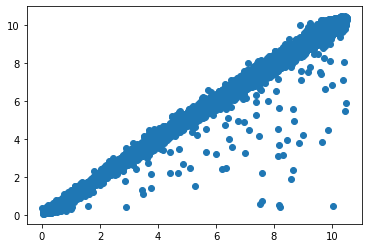

In [8]:
# 如果要观察模型效果，请取消下面注释
'''
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(
    p,
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.show()
'''